In [1]:
import numpy as np
import GPy
import GPyOpt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.integrate import odeint

In [2]:
def objective_function(x, sample=False):
    if not sample:
        x=x[0]
    Time = x[0]
    M = x[1]
    I = x[2]
    T = x[3]
    task = x[4]
    
    t = np.arange(0,Time)
    y0 = [M,I,0,0,0,0,0,0,0]
    sol = odeint(FRP, y0, t, args=(T,))
    end_ = sol.shape[0]-1
    
    if task == 0:
        Mw= np.divide((sol[end_,8]+sol[end_,5])*86.03,(sol[end_,7]+sol[end_,4]))
        return -Mw
    else:
        Mn = (sol[end_,7]+sol[end_,4])*86.03/(sol[end_,6]+sol[end_,3])
        return -Mn


def FRP(y,t,Temperature):
    temp = Temperature+273;
    fr=0.5; 
    kp=4.2E9*np.exp(-6300/(1.98*temp))
    kd=2.7E16*np.exp(-30000/(1.98*temp))
    ktc=1.62E12*np.exp(-2800/(1.98*temp))
    kfm=4.957E8*np.exp(-10480/(1.98*temp));
    kfp=5.177E8*np.exp(-11440/(1.98*temp));
    ktd=0.0;
    kdb=0.66*kp; 
    kfs=0.0;
    
    ydot = np.zeros(9)
    
    ydot[1-1]= -kp*y[4-1]*y[1-1]
    ydot[2-1]= -kd*y[2-1]
    ydot[3-1]= -kfs*y[4-1]*y[3-1]
    ydot[4-1]= 2*fr*kd*y[2-1]-(ktc+ktd)*y[4-1]*y[4-1]
    ydot[5-1]= 2*fr*kd*y[2-1]-(kfm*y[1-1]+kfs*y[3-1])*y[5-1]+kp*y[1-1]*y[4-1]-(ktc+ktd)*y[4-1]*y[5-1]+kfp*(y[4-1]*y[9-1]-y[5-1]*y[8-1])+kdb*y[4-1]*y[8-1]
    if(y[8-1] == 0 or y[7-1] == 0):
        ydot[6-1]= 2*fr*kd*y[2-1]-(kfm*y[1-1]+kfs*y[3-1])*y[6-1]+2*kp*y[1-1]*y[5-1]-(ktc+ktd)*y[4-1]*y[6-1]+kfp*(-y[6-1]*y[8-1])+kdb*(2*y[5-1]*y[8-1]+y[4-1]*y[9-1])
    else:
        ydot[6-1]= 2*fr*kd*y[2-1]-(kfm*y[1-1]+kfs*y[3-1])*y[6-1]+2*kp*y[1-1]*y[5-1]- \
                    (ktc+ktd)*y[4-1]*y[6-1]+kfp*(y[4-1]* \
                    ((y[9-1]/(y[8-1]*y[7-1]))*(2*y[9-1]*y[7-1]-y[8-1]*y[8-1]))-y[6-1]*y[8-1])+ \
                    kdb*(2*y[5-1]*y[8-1]+y[4-1]*y[9-1])


    ydot[7-1]= (kfm*y[1-1]+kfs*y[3-1])*y[4-1]+(ktc/2+ktd)*y[4-1]*y[4-1]-kdb*y[4-1]*y[7-1]
    ydot[8-1]= (kfm*y[1-1]+kfs*y[3-1])*y[5-1]+(ktc+ktd)*y[4-1]*y[5-1]-kdb*y[4-1]*y[8-1] \
                -kfp*(y[4-1]*y[9-1]-y[5-1]*y[8-1])
    if(y[8-1] == 0 or y[7-1] == 0):
        ydot[9-1]= (kfm*y[1-1]+kfs*y[3-1])*y[6-1]+(ktc+ktd)*y[4-1]*y[6-1]-kdb*y[4-1]*y[9-1] \
                    +ktc*y[5-1]*y[5-1]+kfp*(y[6-1]*y[8-1])
    else:
        ydot[9-1]= (kfm*y[1-1]+kfs*y[3-1])*y[6-1]+(ktc+ktd)*y[4-1]*y[6-1]-kdb*y[4-1]*y[9-1] \
                   +ktc*y[5-1]*y[5-1]-kfp*(y[4-1]*((y[9-1]/(y[8-1]*y[7-1]))* \
                   (2*y[9-1]*y[7-1]-y[8-1]*y[8-1]))-y[6-1]*y[8-1])
        
    dydt = ydot
    
    return dydt

In [3]:
bounds = [{'name': 'Time', 'type': 'continuous', 'domain': (30,10000)},
          {'name': 'M', 'type': 'continuous', 'domain': (10, 14)},
          {'name': 'I', 'type': 'continuous', 'domain': (0.00003, 0.00015)},
          {'name': 'T', 'type': 'continuous', 'domain': (60, 80)},
          {'name': 'Task Number', 'type': 'discrete', 'domain': (0, 1)}]

In [4]:
def random_sample(bounds, num_samples):

    n_dim = len(bounds) - 1
    samples = np.zeros((num_samples, n_dim))
    
    for i, bound in enumerate(bounds[:-1]): 
        samples[:, i] = np.random.uniform(bound['domain'][0], bound['domain'][1], num_samples)
    
    return samples

def latin_hypercube_sample(bounds, n_samples):
    
    n_dim = len(bounds) - 1
    samples = np.zeros((n_samples, n_dim))

    for i in range(n_dim):
        lower, upper = bounds[i]["domain"]
        interval = np.linspace(lower, upper, n_samples + 1)
        samples[:, i] = np.random.uniform(interval[:-1], interval[1:], n_samples)
        
    return samples


task0_samples = 3
task1_samples = 80

random_sampling = True

P1 = random_sample(bounds, task0_samples)

if random_sampling:
    P2 = random_sample(bounds, task1_samples)

else:
    P2 = latin_hypercube_sample(bounds, task1_samples)
    
X1 = np.hstack((P1, np.zeros(task0_samples).reshape(-1,1)))
X2 = np.hstack((P2, np.ones(task1_samples).reshape(-1,1)))

Y1 = np.array([objective_function(X, sample=True) for X in X1]).reshape(-1,1)
Y2 = np.array([objective_function(X, sample=True) for X in X2]).reshape(-1,1)

X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

In [5]:
kernel = GPy.kern.Matern52(4, ARD=True)
kernel = GPy.util.multioutput.ICM(4, 2, kernel)

In [6]:
objective = GPyOpt.core.task.SingleObjective(objective_function)

surrogate_model = GPyOpt.models.GPModel(kernel, verbose=False)

search_space = GPyOpt.Design_space(bounds)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(search_space, 'lbfgs')

acquisition = GPyOpt.acquisitions.AcquisitionLCB(surrogate_model, search_space, acquisition_optimizer)
 
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(surrogate_model, search_space, objective, acquisition, 
                                                evaluator, X, Y, normalize_Y=True)

In [7]:
bo.run_optimization(30)

In [8]:
bo.save_evaluations("multi_task_evaluations.csv")

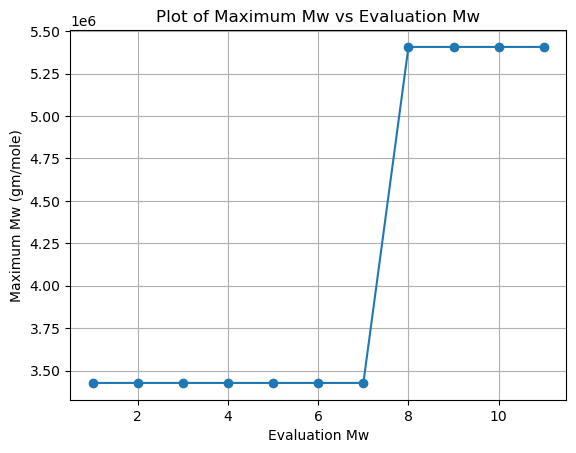

In [9]:
df = pd.read_csv("multi_task_evaluations.csv", sep='\t')
filtered_df = df[df['var_5'] == 0]
df = filtered_df[["Y"]]
df.reset_index(inplace=True, drop=True)
num_rows = len(df)
df['Iteration'] = pd.Series(range(1, num_rows + 1))

min_y = float('inf')
min_iteration = None

iterations = []
min_y_values = []

for index, row in df.iterrows():
    if row['Y'] < min_y:
        min_y = row['Y']
        min_iteration = row['Iteration']
    
    iterations.append(row['Iteration'])
    min_y_values.append(-min_y)

plt.plot(iterations, min_y_values, marker='o', linestyle='-')

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.xlabel('Evaluation Mw')
plt.ylabel('Maximum Mw (gm/mole)')
plt.title('Plot of Maximum Mw vs Evaluation Mw')
plt.grid(True)
plt.show()